Start by doing some basic checks – are there any data issues? Does the data need to be cleaned?

Gather some interesting overall insights about the data. For example -- what is the average transaction amount? How many transactions do customers make each month, on average?

Segment the dataset by transaction date and time. Visualise transaction volume and spending over the course of an average day or week. Consider the effect of any outliers that may distort your analysis.

For a challenge – what insights can you draw from the location information provided in the dataset?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=None

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE
from sklearn.model_selection import LeaveOneOut,cross_val_score,KFold
from sklearn.linear_model import LinearRegression,ElasticNetCV,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
df1 = pd.read_excel('ANZ synthesised transaction dataset.xlsx')
df1.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

In [4]:
df1.shape

(12043, 23)

In [5]:
num_df = df1.select_dtypes(np.number)
num_df.columns

Index(['card_present_flag', 'merchant_code', 'balance', 'age', 'amount'], dtype='object')

In [6]:
cat_df = df1.select_dtypes(include='object')
cat_df.columns

Index(['status', 'bpay_biller_code', 'account', 'currency', 'long_lat',
       'txn_description', 'merchant_id', 'first_name', 'gender',
       'merchant_suburb', 'merchant_state', 'extraction', 'transaction_id',
       'country', 'customer_id', 'merchant_long_lat', 'movement'],
      dtype='object')

In [7]:
# checking null values
df1.isnull().sum()

status                   0
card_present_flag     4326
bpay_biller_code     11158
account                  0
currency                 0
long_lat                 0
txn_description          0
merchant_id           4326
merchant_code        11160
first_name               0
balance                  0
date                     0
gender                   0
age                      0
merchant_suburb       4326
merchant_state        4326
extraction               0
amount                   0
transaction_id           0
country                  0
customer_id              0
merchant_long_lat     4326
movement                 0
dtype: int64

In [8]:
# dropping merchant_code,bpay_biller_code as the % of null values is more than 90%
df1.drop(columns=['bpay_biller_code','merchant_code'],axis=1,inplace =True)
df1.columns

Index(['status', 'card_present_flag', 'account', 'currency', 'long_lat',
       'txn_description', 'merchant_id', 'first_name', 'balance', 'date',
       'gender', 'age', 'merchant_suburb', 'merchant_state', 'extraction',
       'amount', 'transaction_id', 'country', 'customer_id',
       'merchant_long_lat', 'movement'],
      dtype='object')

In [9]:
df1['card_present_flag'].value_counts()

1.0    6194
0.0    1523
Name: card_present_flag, dtype: int64

In [10]:
df1['merchant_state'].value_counts()

NSW    2169
VIC    2131
QLD    1556
WA     1100
SA      415
NT      205
ACT      73
TAS      68
Name: merchant_state, dtype: int64

In [11]:
#we see that males have made more transaction compared to females
df1.groupby('gender')[['transaction_id']].count().reset_index()

,gender,transaction_id
0,F,5758
1,M,6285


In [12]:
df1['movement'].value_counts()

debit     11160
credit      883
Name: movement, dtype: int64

In [13]:
df1['txn_description'].value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

In [14]:
df1['date'].value_counts().head()

2018-09-28    174
2018-08-17    172
2018-10-05    168
2018-10-17    162
2018-09-14    161
Name: date, dtype: int64

In [15]:
df1[['balance','amount','age']].describe().T

,count,mean,std,min,25%,50%,75%,max
balance,12043.0,14704.195553,31503.722652,0.24,3158.585,6432.01,12465.945,267128.52
amount,12043.0,187.933588,592.599934,0.10,16.000,29.00,53.655,8835.98
age,12043.0,30.582330,10.046343,18.00,22.000,28.00,38.000,78.00


In [16]:
# so there are 100 unique customers having 100 unique account numbers who made transactions
df1['customer_id'].value_counts().count()

100

In [17]:
df1['extraction'] = pd.to_datetime(df1['extraction'])

In [18]:
# By using extraction column we made a time column
df1['time'] = df1['extraction'].dt.time
df1['time'].head()

0    01:01:15
1    01:13:45
2    01:26:15
3    01:38:45
4    01:51:15
Name: time, dtype: object

In [19]:
# By using the extraction we acquired converting them to days of that particular date
df1['day_name'] = df1['extraction'].dt.day_name()
df1['day_name'].head()

0    Wednesday
1    Wednesday
2    Wednesday
3    Wednesday
4    Wednesday
Name: day_name, dtype: object

In [20]:
# Creating Month by using the extraction column
df1['month_name'] = df1['extraction'].dt.month_name()
df1['month_name'].head()

0    August
1    August
2    August
3    August
4    August
Name: month_name, dtype: object

In [21]:
# Checking out available months on which transactions took place
df1['month_name'].value_counts()

October      4087
September    4013
August       3943
Name: month_name, dtype: int64

In [22]:
#df1.groupby(['customer_id','account'])[['balance']].mean().reset_index()

In [23]:
# particular customer made how much transaction amount  on each month 
df1.groupby(['customer_id','month_name','movement'])[['amount']].mean()

amount
customer_id    month_name movement             
CUS-1005756958 August     credit     970.470000
                          debit       49.076522
               October    credit     970.470000
                          debit      153.500000
               September  credit     970.470000
                          debit       78.134000
CUS-1117979751 August     credit    3578.650000
                          debit       37.707317
               October    credit    3578.650000
                          debit       44.396897
               September  credit    3578.650000
                          debit      265.230870
CUS-1140341822 August     credit    1916.510000
                          debit       45.480000
               October    credit    1916.510000
                          debit       64.379756
               September  credit    1916.510000
                          debit      114.036500
CUS-1147642491 August     credit    1711.390000
                          debit       80.398800
               October    credit    1711.390000
                          debit       58.759111
               September  credit    1711.390000
                          debit       59.389143
CUS-1196156254 August     credit    3903.730000
                          debit       37.778987
               October    credit    3903.730000
                          debit       38.457460
               September  credit    3903.730000
                          debit       34.554688
CUS-1220154422 August     credit    2282.360000
                          debit       54.565385
               October    credit    2282.360000
                          debit       67.006364
               September  credit    2282.360000
                          debit       73.821212
CUS-1233833708 August     credit     596.330000
                          debit       50.530000
               October    credit     596.330000
                          debit      142.580667
               September  credit     596.330000
                          debit      108.495000
CUS-1271030853 August     credit    1158.150000
                          debit       50.778333
               October    credit    1158.150000
                          debit      280.020588
               September  credit    1158.150000
                          debit       46.708462
CUS-127297539  August     credit    1138.790000
                          debit       32.032698
               October    credit    1138.790000
                          debit       57.577021
               September  credit    1138.790000
                          debit       30.636316
CUS-134193016  August     credit    2023.680000
                          debit       36.747500
               October    credit    2023.680000
                          debit       54.210952
               September  credit    2023.680000
                          debit       46.918750
CUS-134833760  August     credit    3785.780000
                          debit       38.599032
               October    credit    3785.780000
                          debit       67.948235
               September  credit    3785.780000
                          debit      154.137273
CUS-1388323263 August     credit    1043.120000
                          debit       42.421538
               October    credit    1043.120000
                          debit       51.139600
               September  credit    1043.120000
                          debit       45.813243
CUS-1433879684 August     credit    1408.080000
                          debit       46.856222
               October    credit    1408.080000
                          debit       37.755429
               September  credit    1408.080000
                          debit       33.482794
CUS-1462656821 August     credit    3903.950000
                          debit       69.174255
               October    credit    3903.950000
                          debit       52.892000
         

In [24]:
# particular customer has how much balance left at the end of each month in their account
#df1.groupby(['customer_id','month_name'])[['balance']].mean()

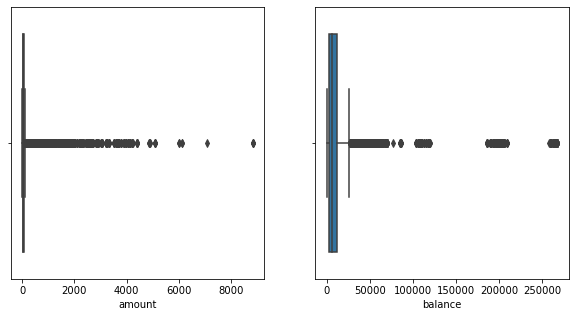

In [25]:
# checking of outliers
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(df1['amount'],ax=ax[0])
sns.boxplot(df1['balance'],ax=ax[1])
plt.show()

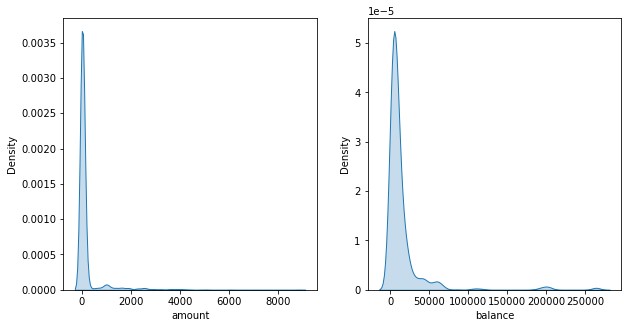

In [26]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.kdeplot(df1['amount'],ax=ax[0],shade = True)
sns.kdeplot(df1['balance'],ax=ax[1],shade = True)
plt.show()

In [27]:
## particular customer made how many transactions on each day
df1.groupby(['customer_id','day_name'])[['transaction_id']].count()

transaction_id
customer_id    day_name                 
CUS-1005756958 Friday                  8
               Monday                  4
               Saturday               13
               Sunday                  9
               Thursday                7
               Tuesday                25
               Wednesday               7
CUS-1117979751 Friday                  8
               Monday                 26
               Saturday               15
               Sunday                 17
               Thursday               10
               Tuesday                 5
               Wednesday              19
CUS-1140341822 Friday                 18
               Monday                  8
               Saturday               13
               Sunday                 10
               Thursday               13
               Tuesday                 6
               Wednesday              12
CUS-1147642491 Friday                 18
               Monday                 34
               Saturday               21
               Sunday                 13
               Thursday                4
               Tuesday                14
               Wednesday              14
CUS-1196156254 Friday                 59
               Monday                 21
               Saturday               17
               Sunday                 41
               Thursday               32
               Tuesday                40
               Wednesday              35
CUS-1220154422 Friday                 21
               Monday                  4
               Saturday                9
               Sunday                  6
               Thursday               20
               Tuesday                 5
               Wednesday              10
CUS-1233833708 Friday                  4
               Monday                  4
               Saturday               10
               Sunday                  2
               Thursday               14
               Tuesday                 5
               Wednesday               5
CUS-1271030853 Friday                 11
               Monday                 39
               Saturday               10
               Sunday                  9
               Thursday                7
               Tuesday                 8
               Wednesday              33
CUS-127297539  Friday                 64
               Monday                 13
               Saturday               39
               Sunday                 17
               Thursday               20
               Tuesday                23
               Wednesday              23
CUS-134193016  Friday                 36
               Monday                  4
               Saturday                8
               Sunday                  4
               Thursday                4
               Tuesday                16
               Wednesday               4
CUS-134833760  Friday                 14
               Monday                  5
               Saturday                6
               Sunday                 10
               Thursday               17
               Tuesday                17
               Wednesday               8
CUS-1388323263 Friday                  9
               Monday                 17
               Saturday               24
               Sunday                  9
               Thursday                8
               Tuesday                16
               Wednesday              19
CUS-1433879684 Friday                 42
               Monday                  6
               Saturday               17
               Sunday                 17
               Thursday               34
               Tuesday                16
               Wednesday              23
CUS-1462656821 Friday                 12
               Monday                  6
               Saturday               13
               Sunday                  9
               Thursday               33
        

In [28]:
# particular customer made how much amount of transactions on each day
df1.groupby(['customer_id','day_name'])[['amount']].mean()

amount
customer_id    day_name              
CUS-1005756958 Friday       62.583750
               Monday       14.562500
               Saturday     63.958462
               Sunday       53.833333
               Thursday     88.007143
               Tuesday     538.677200
               Wednesday    44.444286
CUS-1117979751 Friday       39.702500
               Monday      997.146154
               Saturday    109.148667
               Sunday       21.831176
               Thursday    451.195000
               Tuesday      40.342000
               Wednesday    53.627895
CUS-1140341822 Friday      665.835000
               Monday       41.021250
               Saturday     43.659231
               Sunday      181.891000
               Thursday    123.864615
               Tuesday      49.576667
               Wednesday    33.601667
CUS-1147642491 Friday       56.852222
               Monday      684.309412
               Saturday     40.346190
               Sunday      102.018462
               Thursday     39.150000
               Tuesday     114.027857
               Wednesday    54.604286
CUS-1196156254 Friday       39.992712
               Monday       35.801905
               Saturday     38.387647
               Sunday       36.717805
               Thursday     30.536875
               Tuesday      39.838500
               Wednesday   806.016286
CUS-1220154422 Friday      802.054286
               Monday      103.007500
               Saturday     76.356667
               Sunday       74.796667
               Thursday     51.830500
               Tuesday      51.576000
               Wednesday    91.046000
CUS-1233833708 Friday       73.600000
               Monday      100.412500
               Saturday     35.959000
               Sunday       39.990000
               Thursday    603.437143
               Tuesday      52.774000
               Wednesday   107.586000
CUS-1271030853 Friday       59.620000
               Monday       61.526410
               Saturday     41.106000
               Sunday      821.721111
               Thursday     38.204286
               Tuesday      55.851250
               Wednesday   530.413333
CUS-127297539  Friday      265.110156
               Monday       39.545385
               Saturday     39.419744
               Sunday       30.047647
               Thursday     68.668500
               Tuesday      15.467391
               Wednesday    26.016087
CUS-134193016  Friday      430.038056
               Monday       83.520000
               Saturday     40.367500
               Sunday       83.180000
               Thursday     32.745000
               Tuesday      20.995000
               Wednesday    73.200000
CUS-134833760  Friday     1917.637857
               Monday      116.936000
               Saturday     51.193333
               Sunday       53.152000
               Thursday     59.441765
               Tuesday      34.777647
               Wednesday   296.393750
CUS-1388323263 Friday       48.988889
               Monday       58.663529
               Saturday     24.855000
               Sunday       77.234444
               Thursday     59.196250
               Tuesday      44.525000
               Wednesday   777.075789
CUS-1433879684 Friday       37.962619
               Monday       17.773333
               Saturday     33.441765
               Sunday       64.868824
               Thursday     37.412059
               Tuesday      40.071250
               Wednesday   446.863478
CUS-1462656821 Friday       49.093333
               Monday       62.178333
               Saturday     41.086923
               Sunday      101.697778
               Thursday     76.903939
               Tuesday      80.331765
               Wednesday  1084.466538
CUS-1478398256 Friday     1244.045556
               Monday       60.376000
               Saturday     92.111111
               Sunday       47.223750
               Thursday     51.048571
               Tuesday      74.717826
   

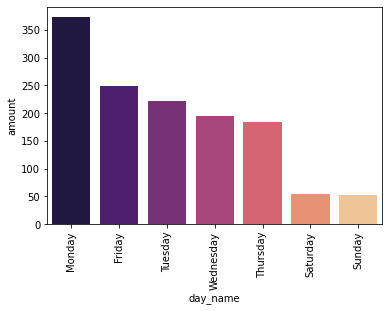

In [29]:
g1 = df1.groupby('day_name')[['amount']].mean().sort_values(by='amount',ascending=False).reset_index()
sns.barplot(g1['day_name'],g1['amount'],palette = 'magma')
plt.xticks(rotation=90)
plt.show()

In [30]:
# we can see that maximun amount of transaction happens on monday,and least on saturday and sunday as the banks remain closed

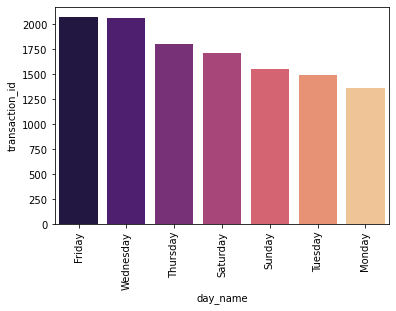

In [31]:
g2 = df1.groupby('day_name')[['transaction_id']].count().sort_values(by='transaction_id',ascending=False).reset_index()
sns.barplot(g2['day_name'],g2['transaction_id'],palette = 'magma')
plt.xticks(rotation=90)
plt.show()

In [32]:
# we see that maximun number of transactions has happened on friday

In [33]:
df1.drop(columns = ['currency'],axis=1,inplace = True)

In [34]:
df1.head(2)

,status,card_present_flag,account,long_lat,txn_description,merchant_id,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement,time,day_name,month_name
0,authorized,1.0,ACC-1598451071,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01 01:01:15+00:00,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit,01:01:15,Wednesday,August
1,authorized,0.0,ACC-1598451071,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01 01:13:45+00:00,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit,01:13:45,Wednesday,August


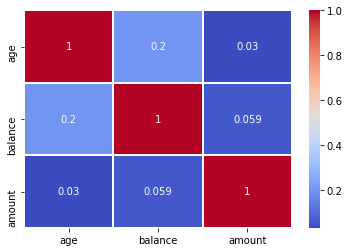

In [35]:
# correlation between the numerical features
sns.heatmap(df1[['age','balance','amount']].corr(),linewidths=1,cmap='coolwarm',annot=  True)
plt.show()

In [36]:
df1['long'] = df1['long_lat'].apply(lambda x:x.split(' ')[0])
df1['lat'] = df1['long_lat'].apply(lambda x:x.split(' ')[1])

In [37]:
df1.columns

Index(['status', 'card_present_flag', 'account', 'long_lat', 'txn_description',
       'merchant_id', 'first_name', 'balance', 'date', 'gender', 'age',
       'merchant_suburb', 'merchant_state', 'extraction', 'amount',
       'transaction_id', 'country', 'customer_id', 'merchant_long_lat',
       'movement', 'time', 'day_name', 'month_name', 'long', 'lat'],
      dtype='object')

In [38]:
df1.drop(['extraction','long_lat','first_name','merchant_long_lat','merchant_id'],axis=1,inplace=True)

In [39]:
df1['txn_description'].value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

In [40]:
# particular customer made how many transactions on each month
#df1.groupby(['customer_id','movement','txn_description','date'])[['date']].count()

In [41]:
df1.groupby(['customer_id','month_name','movement','txn_description'])[['amount','balance']].mean()

amount        balance
customer_id    month_name movement txn_description                            
CUS-1005756958 August     credit   PAY/SALARY        970.470000    1590.795000
                          debit    PAYMENT           144.000000    1027.810000
                                   PHONE BANK        182.000000    1255.670000
                                   POS                28.504545     981.927273
                                   SALES-POS          50.821000     643.223000
               October    credit   PAY/SALARY        970.470000    7740.290000
                          debit    PAYMENT           144.000000    7304.266667
                                   PHONE BANK        182.000000    8467.560000
               September  credit   PAY/SALARY        970.470000    4069.505000
                          debit    PAYMENT           144.000000    3768.676667
                                   PHONE BANK        182.000000    4229.210000
                                   POS                30.227500    3432.300000
                                   SALES-POS          23.215000    3171.895000
CUS-1117979751 August     credit   PAY/SALARY       3578.650000    7346.760000
                          debit    PAYMENT            71.692308    7073.756923
                                   POS                26.281429    6442.664286
                                   SALES-POS          17.575714    6674.242857
               October    credit   PAY/SALARY       3578.650000   15565.300000
                          debit    PAYMENT            69.428571   14935.440714
                                   POS                16.151250   14468.805000
                                   SALES-POS          26.614286   12542.730000
               September  credit   PAY/SALARY       3578.650000   11155.500000
                          debit    INTER BANK       1001.000000    7282.510000
                                   PAYMENT           157.923077    9717.395385
                                   POS                27.305000    8551.042500
                                   SALES-POS         587.418000    8647.680000
CUS-1140341822 August     credit   PAY/SALARY       1916.510000    3414.425000
                          debit    INTER BANK         90.000000    2254.010000
                                   PAYMENT           142.000000    3209.265000
                                   POS                32.210000    1706.045000
                                   SALES-POS          14.733333    1966.796667
               October    credit   PAY/SALARY       1916.510000    7594.515000
                          debit    INTER BANK         90.000000    7183.950000
                                   PAYMENT           142.000000    7118.725000
                                   POS                29.621739    6868.636087
                                   SALES-POS         105.618000    7073.695333
               September  credit   PAY/SALARY       1916.510000    6516.220000
                          debit    INTER BANK         90.000000    7046.000000
                                   PAYMENT           142.000000    5433.065000
                                   POS                45.527500    5457.204167
                                   SALES-POS         272.080000    4937.024000
CUS-1147642491 August     credit   PAY/SALARY       1711.390000    3732.825000
                          debit    PAYMENT            94.375000    3303.468750
                                   POS               103.874000    3748.869000
                                   SALES-POS          30.890000    4349.868571
               October    credit   PAY/SALARY       1711.390000   13434.820000
                          debit    INTER BANK        125.000000   10967.720000
                                   PAYMENT            94.400000   12993.785000
                                   POS                34.025714   13412.487143
                            

In [42]:
df3 = df1[(df1['txn_description']=='PAY/SALARY') & (df1['movement']=='credit')]
df3.head()

,status,card_present_flag,account,txn_description,balance,date,gender,age,merchant_suburb,merchant_state,amount,transaction_id,country,customer_id,movement,time,day_name,month_name,long,lat
50,posted,NaN,ACC-588564840,PAY/SALARY,8342.11,2018-08-01,M,23,NaN,NaN,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,CUS-1462656821,credit,11:00:00,Wednesday,August,151.27,-33.76
61,posted,NaN,ACC-1650504218,PAY/SALARY,2040.58,2018-08-01,F,23,NaN,NaN,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,CUS-2500783281,credit,12:00:00,Wednesday,August,145.01,-37.93
64,posted,NaN,ACC-3326339947,PAY/SALARY,3158.51,2018-08-01,M,22,NaN,NaN,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,CUS-326006476,credit,12:00:00,Wednesday,August,151.18,-33.80
68,posted,NaN,ACC-3541460373,PAY/SALARY,2517.66,2018-08-01,M,24,NaN,NaN,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,CUS-1433879684,credit,13:00:00,Wednesday,August,145.00,-37.83
70,posted,NaN,ACC-2776252858,PAY/SALARY,2271.79,2018-08-01,F,43,NaN,NaN,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,CUS-4123612273,credit,13:00:00,Wednesday,August,144.95,-37.76


In [43]:
df3.isnull().sum()

status                 0
card_present_flag    883
account                0
txn_description        0
balance                0
date                   0
gender                 0
age                    0
merchant_suburb      883
merchant_state       883
amount                 0
transaction_id         0
country                0
customer_id            0
movement               0
time                   0
day_name               0
month_name             0
long                   0
lat                    0
dtype: int64

In [44]:
df3.drop(['card_present_flag','txn_description','movement','status','merchant_suburb','merchant_state'],axis=1,inplace=True)

In [45]:
df3.nunique()

account           100
balance           883
date               65
gender              2
age                33
amount            100
transaction_id    883
country             1
customer_id       100
time                7
day_name            5
month_name          3
long               87
lat                85
dtype: int64

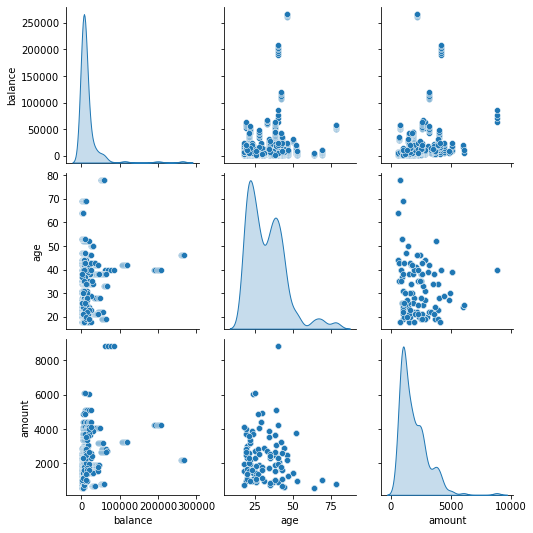

In [46]:
sns.pairplot(df3,diag_kind='kde')
plt.show()

In [47]:
#df3.groupby(['customer_id','month_name'])[['date']].count().reset_index()

In [48]:
unique_id = df3['customer_id'].unique()

In [49]:
demo = df3[(df3['customer_id'] == unique_id[15])][['date','amount']].reset_index(drop=True)
demo

,date,amount
0,2018-08-02,2218.73
1,2018-08-30,2218.73
2,2018-09-13,2218.73
3,2018-09-27,2218.73
4,2018-10-11,2218.73
5,2018-10-25,2218.73


In [50]:
diff = []
for i in range(0,len(demo)-1):
    diff.append((demo.date[i+1]-demo.date[i]).days)
diff

[28, 14, 14, 14, 14]

In [51]:
annual_sal = pd.DataFrame(data= df3['customer_id'].unique(),columns=['Customer_id'])

In [52]:
freq_df = []
amt_df = []
for i in annual_sal['Customer_id']:
    salary = df3[(df3['customer_id']==i)][['date','amount']].reset_index(drop=True)
    cont = len(salary)
    if cont == 0:
        freq_df.append(np.nan)
        amt_df.append(np.nan)
    else:
        days_diff = []
        for j in range(len(salary)-1):
            days_diff.append((salary.date[j+1]-salary.date[j]).days)
        freq_df.append(max(days_diff))
        amt_df.append(salary['amount'].mode()[0])
        

In [53]:
annual_sal['day_diff'] = freq_df
annual_sal['sal_amt'] = amt_df
annual_sal['annual_salary'] = round(annual_sal['sal_amt']/annual_sal['day_diff'] * 365.25,3)

In [54]:
#gender column made for the unique customers
sex = []
for i in annual_sal['Customer_id']:
    sex.append(df3[(df3['customer_id']==i)]['gender'].mode()[0])

In [55]:
#age column made for the unique customers
age = []
for i in annual_sal['Customer_id']:
    age.append(df3[(df3['customer_id']==i)]['age'].mode()[0])

In [56]:
#balance column made for the unique customers
Acc_Bal = []
for i in annual_sal['Customer_id']:
    Acc_Bal.append(df3[(df3['customer_id']==i)]['balance'].median())

In [57]:
C_lat = []
for i in annual_sal['Customer_id']:
    C_lat.append(df3[(df3['customer_id']==i)]['lat'].mode()[0])

In [58]:
C_long = []
for i in annual_sal['Customer_id']:
    C_long.append(df3[(df3['customer_id']==i)]['long'].mode()[0])

In [59]:
C_loc = []
for i in annual_sal['Customer_id']:
    C_loc.append(df1[(df1['customer_id']==i)]['merchant_state'].mode()[0])

In [60]:
new_cols = pd.DataFrame({'Age':age,'Sex':sex,'Acc_Balance':Acc_Bal,'C_lat':C_lat,'C_long':C_long,'C_loc':C_loc})

In [61]:
annual_df = pd.concat([annual_sal,new_cols],axis=1)
annual_df.head()

,Customer_id,day_diff,sal_amt,annual_salary,Age,Sex,Acc_Balance,C_lat,C_long,C_loc
0,CUS-1462656821,14,3903.95,101851.267,23,M,15523.690,-33.76,151.27,NSW
1,CUS-2500783281,7,1626.48,84867.403,23,F,10832.200,-37.93,145.01,VIC
2,CUS-326006476,7,983.36,51310.320,22,M,8307.525,-33.80,151.18,NSW
3,CUS-1433879684,14,1408.08,36735.801,24,M,3874.970,-37.83,145.00,VIC
4,CUS-4123612273,7,1068.04,55728.801,43,F,5011.890,-37.76,144.95,VIC


In [62]:
sal_data = annual_df.to_csv('salary.csv',index= True)

In [63]:
#location findings of the customers from latitude and longitude

In [64]:
import geopy

In [65]:
from geopy.geocoders import Nominatim
  
# Initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")
  
# Assign Latitude & Longitude
Latitude = "-37.93"
Longitude = "145.01"
  
# Dsiaplying Latitude and Longitude
#print("Latitude: ", Latitude)
#print("Longitude: ", Longitude)
  
# Get location with geocode
location = geolocator.reverse((Latitude+","+Longitude))
  
# Dsiplay location
print("\nLocation of the given Latitude and Longitude:")
print(location)


Location of the given Latitude and Longitude:
South Road, Brighton East, Hampton, Melbourne, City of Bayside, Victoria, 3188, Australia


In [66]:
location.raw['address'].get('city')

'Melbourne'

In [67]:
from geopy.geocoders import Nominatim

# Initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")
loc=[]
for i in range(len(annual_df)):
    location = geolocator.geocode(annual_df.loc[i,'C_lat']+","+annual_df.loc[i,'C_long'])
    loc.append(location) 

In [68]:
loc[0:5]

[Location(Gulliver Street, Brookvale, Sydney, Northern Beaches Council, Northern Beaches, New South Wales, 2100, Australia, (-33.7602365, 151.2704422, 0.0)),
 Location(South Road, Brighton East, Hampton, Melbourne, City of Bayside, Victoria, 3188, Australia, (-37.9303747, 145.0138243, 0.0)),
 Location(Greendale Towers, 8-14, Ellis Street, Chatswood, Sydney, Willoughby City Council, Lower North Shore, New South Wales, 2067, Australia, (-33.800117150000005, 151.17990946797408, 0.0)),
 Location(Richmond Primary School, Barkly Avenue, Richmond, Burnley, Melbourne, City of Yarra, Victoria, 3121, Australia, (-37.82974365, 144.99959578492627, 0.0)),
 Location(Sheffield Street, Brunswick West, Melbourne, City of Moreland, Victoria, 3055, Australia, (-37.7601627, 144.9502181, 0.0))]

In [69]:
bal = df3[(df3['customer_id']== 'CUS-1462656821')][['date','balance','amount','month_name']].reset_index()
bal

,index,date,balance,amount,month_name
0,50,2018-08-01,8342.11,3903.95,August
1,1826,2018-08-15,10724.87,3903.95,August
2,3553,2018-08-29,13030.74,3903.95,August
3,5419,2018-09-12,15523.69,3903.95,September
4,7291,2018-09-26,17906.31,3903.95,September
5,9162,2018-10-10,21236.51,3903.95,October
6,11035,2018-10-24,24451.16,3903.95,October


In [70]:
diff = []
for i in range(0,len(bal)-1):
    diff.append((bal.date[i+1]-bal.date[i]).days)
diff

[14, 14, 14, 14, 14, 14]

In [71]:
df3[(df3['customer_id']== 'CUS-1462656821')]['balance'].median()

15523.69

In [72]:
df4 = df1[(df1['movement']=='debit')]
df4.head(3)

,status,card_present_flag,account,txn_description,balance,date,gender,age,merchant_suburb,merchant_state,amount,transaction_id,country,customer_id,movement,time,day_name,month_name,long,lat
0,authorized,1.0,ACC-1598451071,POS,35.39,2018-08-01,F,26,Ashmore,QLD,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,debit,01:01:15,Wednesday,August,153.41,-27.95
1,authorized,0.0,ACC-1598451071,SALES-POS,21.20,2018-08-01,F,26,Sydney,NSW,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,debit,01:13:45,Wednesday,August,153.41,-27.95
2,authorized,1.0,ACC-1222300524,POS,5.71,2018-08-01,M,38,Sydney,NSW,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,debit,01:26:15,Wednesday,August,151.23,-33.94
